### Financial SQL ETL Pipeline

In [1]:
pip install -r requeriments.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requeriments.txt'


In [16]:
import pandas as pd
import yfinance as yf
import sqlite3
import matplotlib.pyplot as plt

**Extraccion de datos**

In [3]:
symbols = ['AAPL', 'MSFT', 'TSLA']

# DataFrame principal (precios históricos)
all_data = pd.DataFrame()
dividends_data = pd.DataFrame()
splits_data = pd.DataFrame()

for symbol in symbols:
    ticker = yf.Ticker(symbol)
    
    #  Precios históricos (incluye Adj Close ajustado por splits/dividends)
    hist = ticker.history(period="5y", actions=True)  # actions=True incluye dividends/splits como columnas
    hist['symbol'] = symbol
    all_data = pd.concat([all_data, hist])
    
    #  Dividends históricos puros (Serie con fechas y montos)
    divs = ticker.dividends
    divs.name = 'dividend_amount'
    divs = divs.to_frame()
    divs['symbol'] = symbol
    divs['event_date'] = divs.index
    dividends_data = pd.concat([dividends_data, divs])
    
    # Stock Splits históricos puros (Serie con fechas y ratios)
    splits = ticker.splits
    splits.name = 'split_ratio'
    splits = splits.to_frame()
    splits['symbol'] = symbol
    splits['event_date'] = splits.index
    splits_data = pd.concat([splits_data, splits])

# Limpieza de índices (fechas como columnas)
all_data.reset_index(inplace=True)
dividends_data.reset_index(drop=True, inplace=True)
splits_data.reset_index(drop=True, inplace=True)

print("Sample Precios (con dividends/splits como 0s normales):")
print(all_data[['Date', 'symbol', 'Dividends', 'Stock Splits']].tail(5))
print("\nDividends Históricos (solo fechas reales):")
print(dividends_data.tail(5))
print("\nStock Splits Históricos (solo fechas reales):")
print(splits_data.tail(5))


Sample Precios (con dividends/splits como 0s normales):
                          Date symbol  Dividends  Stock Splits
3763 2025-09-29 00:00:00-04:00   TSLA        0.0           0.0
3764 2025-09-30 00:00:00-04:00   TSLA        0.0           0.0
3765 2025-10-01 00:00:00-04:00   TSLA        0.0           0.0
3766 2025-10-02 00:00:00-04:00   TSLA        0.0           0.0
3767 2025-10-03 00:00:00-04:00   TSLA        0.0           0.0

Dividends Históricos (solo fechas reales):
     dividend_amount symbol                event_date
170             0.75   MSFT 2024-08-15 00:00:00-04:00
171             0.83   MSFT 2024-11-21 00:00:00-05:00
172             0.83   MSFT 2025-02-20 00:00:00-05:00
173             0.83   MSFT 2025-05-15 00:00:00-04:00
174             0.83   MSFT 2025-08-21 00:00:00-04:00

Stock Splits Históricos (solo fechas reales):
    split_ratio symbol                event_date
11          2.0   MSFT 1998-02-23 00:00:00-05:00
12          2.0   MSFT 1999-03-29 00:00:00-05:00
13  

In [4]:
all_data['daily_return'] = (all_data['Close'] - all_data['Open']) / all_data['Open'] * 100

In [5]:
all_data['daily_return'].fillna(0, inplace=True)

C:\Users\lauti\AppData\Local\Temp\ipykernel_8516\3425507029.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_data['daily_return'].fillna(0, inplace=True)


In [6]:
all_data = all_data.merge(
    dividends_data[['event_date', 'symbol', 'dividend_amount']],
    left_on=['Date', 'symbol'],
    right_on=['event_date', 'symbol'],
    how='left'
)
all_data.rename(columns={'dividend_amount': 'dividend_adjusted'}, inplace=True)
all_data.drop('event_date', axis=1, inplace=True, errors='ignore')

all_data = all_data.merge(
    splits_data[['event_date', 'symbol', 'split_ratio']],
    left_on=['Date', 'symbol'],
    right_on=['event_date', 'symbol'],
    how='left'
)
all_data.drop('event_date', axis=1, inplace=True, errors='ignore')

In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3768 entries, 0 to 3767
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype                           
---  ------             --------------  -----                           
 0   Date               3768 non-null   datetime64[ns, America/New_York]
 1   Open               3768 non-null   float64                         
 2   High               3768 non-null   float64                         
 3   Low                3768 non-null   float64                         
 4   Close              3768 non-null   float64                         
 5   Volume             3768 non-null   int64                           
 6   Dividends          3768 non-null   float64                         
 7   Stock Splits       3768 non-null   float64                         
 8   symbol             3768 non-null   object                          
 9   daily_return       3768 non-null   float64                         
 10  dividend_adj

In [8]:
# Llena NaN en columnas mergeadas
all_data['dividend_adjusted'].fillna(0, inplace=True)
all_data['split_ratio'].fillna(0, inplace=True)

C:\Users\lauti\AppData\Local\Temp\ipykernel_8516\904561460.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_data['dividend_adjusted'].fillna(0, inplace=True)
C:\Users\lauti\AppData\Local\Temp\ipykernel_8516\904561460.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [9]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3768 entries, 0 to 3767
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype                           
---  ------             --------------  -----                           
 0   Date               3768 non-null   datetime64[ns, America/New_York]
 1   Open               3768 non-null   float64                         
 2   High               3768 non-null   float64                         
 3   Low                3768 non-null   float64                         
 4   Close              3768 non-null   float64                         
 5   Volume             3768 non-null   int64                           
 6   Dividends          3768 non-null   float64                         
 7   Stock Splits       3768 non-null   float64                         
 8   symbol             3768 non-null   object                          
 9   daily_return       3768 non-null   float64                         
 10  dividend_adj

In [10]:
# Retorno ajustado por dividendos 
all_data['dividend_adj_return'] = (all_data['Close'] + all_data['dividend_adjusted'] - all_data['Open']) / all_data['Open'] * 100

**Load a SQL**

In [11]:
conn = sqlite3.connect('finance.db')
all_data.to_sql('prices_enriched', conn, if_exists='replace', index=False)

3768

**Transformación en sql**

In [12]:
cursor = conn.cursor()

# Crear vista
cursor.execute("DROP VIEW IF EXISTS enriched_prices;")
cursor.execute("""
    CREATE VIEW enriched_prices AS
    SELECT Date, symbol, Close, daily_return, dividend_adjusted, split_ratio
    FROM prices_enriched
    WHERE daily_return IS NOT NULL;
""")

# Volatilidad
cursor.execute("""
    SELECT 
        symbol,
        SQRT(AVG(diff_squared)) AS volatility
    FROM (
        SELECT 
            symbol,
            daily_return,
            (daily_return - AVG(daily_return) OVER (PARTITION BY symbol)) * 
            (daily_return - AVG(daily_return) OVER (PARTITION BY symbol)) AS diff_squared
        FROM prices_enriched
        WHERE daily_return IS NOT NULL
    )
    GROUP BY symbol
    ORDER BY volatility DESC LIMIT 5;
""")
print("Top 5 Symbols by Volatility:", cursor.fetchall())

# Dividend Yield
cursor.execute("""
    SELECT 
        strftime('%Y', Date) AS year,
        symbol,
        SUM(dividend_adjusted) / AVG(Close) * 100 AS dividend_yield
    FROM prices_enriched
    WHERE dividend_adjusted > 0
    GROUP BY year, symbol
    ORDER BY dividend_yield DESC LIMIT 5;
""")
print("Top Dividend Yields:", cursor.fetchall())

# Avg Return
cursor.execute("""
    SELECT symbol, AVG(daily_return) AS avg_return
    FROM prices_enriched
    GROUP BY symbol
    ORDER BY avg_return DESC LIMIT 5;
""")
print("Top 5 Symbols by Avg Return:", cursor.fetchall())

Top 5 Symbols by Volatility: [('TSLA', 3.1562074196779184), ('AAPL', 1.5022161916376748), ('MSFT', 1.340327378757526)]
Top Dividend Yields: [('2022', 'MSFT', 0.9593070550441605), ('2023', 'MSFT', 0.8903550233722196), ('2021', 'MSFT', 0.8517287595751488), ('2024', 'MSFT', 0.74546707398746), ('2021', 'AAPL', 0.6266734089013029)]
Top 5 Symbols by Avg Return: [('AAPL', 0.1078313304780094), ('MSFT', 0.042256763610551154), ('TSLA', 0.02315314802362829)]


In [ ]:
#   Retorno Acumulado (Log Returns) 
cumulative_returns_query = """
WITH CalculatedLogReturn AS (
    SELECT
        Date,
        symbol,
        LOG(1 + daily_return / 100) AS log_return
    FROM
        prices_enriched
)
SELECT
    Date,
    symbol,
    SUM(log_return) OVER (
        PARTITION BY symbol
        ORDER BY Date
    ) AS cumulative_log_return
FROM
    CalculatedLogReturn
ORDER BY
    symbol, Date;
"""
df_cumulative_returns = pd.read_sql(cumulative_returns_query, conn)


#  Desviación del Promedio Móvil (MA Deviation) 
ma_deviation_query = """
WITH CalculatedMA AS (
    SELECT
        Date,
        symbol,
        Close,
        AVG(Close) OVER (
            PARTITION BY symbol
            ORDER BY Date
            ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
        ) AS moving_avg_30d
    FROM
        prices_enriched
)
SELECT
    Date,
    symbol,
    Close,
    moving_avg_30d,
    (Close - moving_avg_30d) * 100.0 / moving_avg_30d AS ma_deviation_pct
FROM
    CalculatedMA
WHERE
    moving_avg_30d IS NOT NULL
ORDER BY
    symbol, Date;
"""
df_ma_deviation = pd.read_sql(ma_deviation_query, conn)


#  Eventos Corporativos (Splits y Dividendos) 
events_query = """
SELECT
    Date,
    symbol,
    dividend_adjusted AS amount,
    'Dividend' AS event_type
FROM
    prices_enriched
WHERE
    dividend_adjusted > 0

UNION ALL

SELECT
    Date,
    symbol,
    split_ratio AS amount,
    'Split' AS event_type
FROM
    prices_enriched
WHERE
    split_ratio > 0
ORDER BY
    Date, symbol, event_type;
"""
df_events = pd.read_sql(events_query, conn)

conn.close()
"""
"""

'\n'

**Visualizaciones**

Gráfico de Retorno Acumulado generado en plots/cumulative_log_returns.png


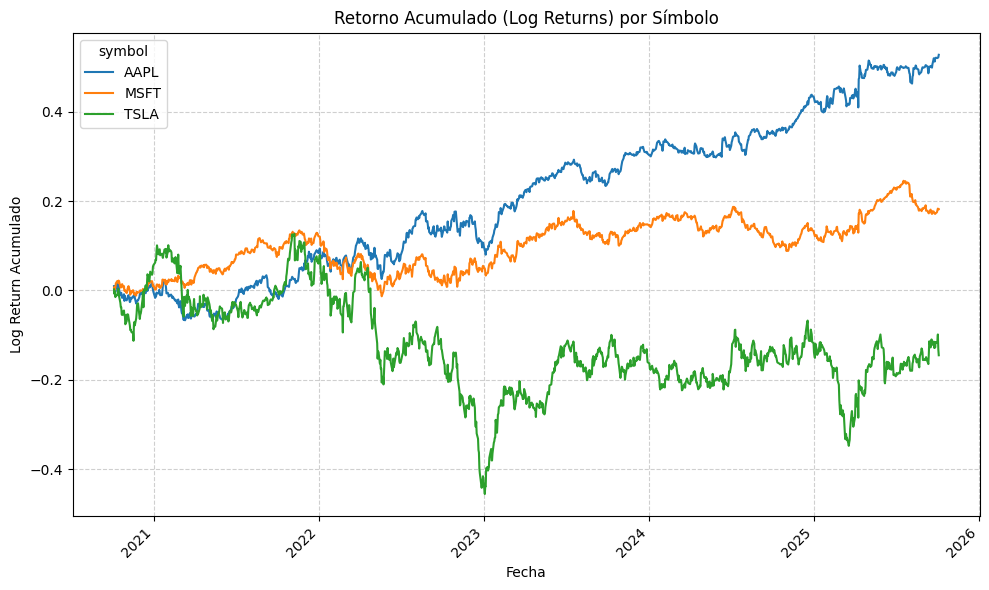

In [ ]:

df_cumulative_returns['Date'] = pd.to_datetime(df_cumulative_returns['Date'], utc=True)
# Reorganizamos el DataFrame para graficar múltiples líneas por símbolo
pivot_cum_returns = df_cumulative_returns.pivot(index='Date', columns='symbol', values='cumulative_log_return')

# Generar el gráfico
plt.figure(figsize=(10, 6))
pivot_cum_returns.plot(ax=plt.gca())

# Configuración y guardado del gráfico
plt.title('Retorno Acumulado (Log Returns) por Símbolo')
plt.xlabel('Fecha')
plt.ylabel('Log Return Acumulado')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('plots/cumpulative_returns_plot.png')

print("Gráfico de Retorno Acumulado generado en plots/cumulative_log_returns.png")

El Log Return Acumulado es una métrica estándar para medir el retorno total.

**AAPL** muestra un rendimiento compuesto netamente superior (0.5269) al de sus pares en este periodo. Aunque TSLA tuvo picos de crecimiento, su caída reciente la deja con un retorno acumulado negativo.

**MSFT** tiene un retorno positivo y constante, reflejando su estabilidad como una empresa de gran capitalización.

**TSLA** termina el periodo con un retorno acumulado negativo (-0.1449), a pesar de ser la acción más volátil. Esto ilustra la diferencia entre volatilidad (riesgo) y retorno re

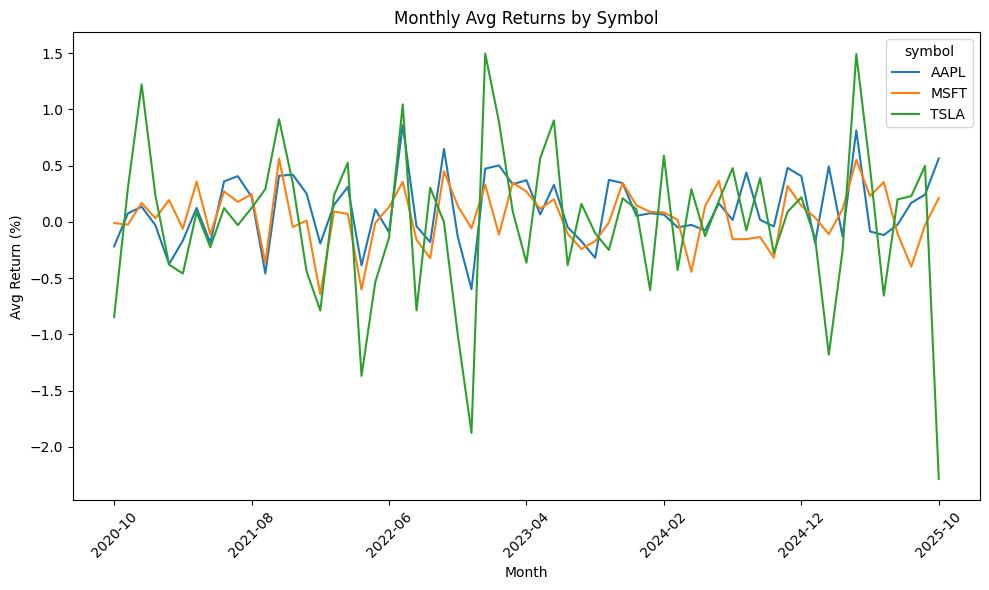

In [31]:
# Monthly Avg Returns 
conn = sqlite3.connect('finance.db')

df_returns = pd.read_sql("""
    SELECT 
        strftime('%Y-%m', Date) AS month,
        symbol,
        AVG(daily_return) AS avg_return
    FROM prices_enriched
    WHERE daily_return IS NOT NULL
    GROUP BY month, symbol
""", conn)
pivot_returns = df_returns.pivot(index='month', columns='symbol', values='avg_return')
pivot_returns.plot(figsize=(10, 6))
plt.title('Monthly Avg Returns by Symbol')
plt.xlabel('Month')
plt.ylabel('Avg Return (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/monthly_returns_plot.png')
plt.show()

Este gráfico se utiliza para identificar patrones estacionales o periodos de riesgo sistémico al mostrar el promedio de ganacias/pérdidas diarias dentro de cada mes. 


Volatilidad Mensual: Las líneas con mayores y más frecuentes picos y valles (como TSLA y AAPL) indican una mayor volatilidad mensual. TSLA, aunque su retorno diario promedio general es bajo (0.023%), tiene los movimientos mensuales más erráticos.

 MSFT (retorno diario promedio: 0.042%) y AAPL (retorno diario promedio: 0.108%) muestran patrones de retorno positivo más consistentes en el tiempo, aunque AAPL lidera en el retorno promedio general.

 Los valles pronunciados en los mismos meses para las tres acciones sugieren la presencia de riesgo de mercado o eventos económicos que afectaron a todo el sector.

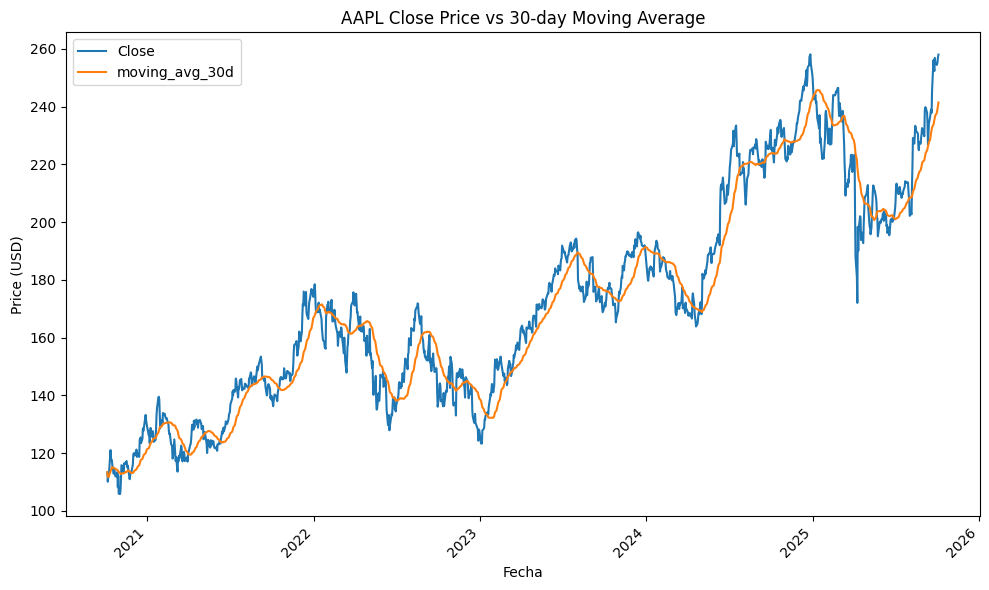

In [29]:
# AAPL Close vs 30-day Moving Average
conn = sqlite3.connect('finance.db')
df_ma = pd.read_sql("""
    SELECT 
        Date, symbol, Close,
        AVG(Close) OVER (
            PARTITION BY symbol 
            ORDER BY Date 
            ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
        ) AS moving_avg_30d
    FROM prices_enriched
    WHERE symbol = 'AAPL'
""", conn)
conn.close() 

df_ma['Date'] = pd.to_datetime(df_ma['Date'], utc=True) # utc=True para la seguridad de la zona horaria

df_ma.plot(x='Date', y=['Close', 'moving_avg_30d'], figsize=(10, 6), ax=plt.gca())
plt.title('AAPL Close Price vs 30-day Moving Average')
plt.xlabel('Fecha')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45) 
plt.tight_layout()

plt.savefig('plots/aapl_moving_avg.png')

Gráfico de análisis técnico que visualiza el Promedio Móvil Simple (MA) de 30 días, una herramienta esencial de momentum y tendencia.

Identificación de Tendencia: Si el precio de cierre (línea azul) se mantiene consistentemente por encima del MA de 30 días (línea naranja), indica una fuerte tendencia alcista.